In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import admix
from admix.data import zsc2pval, pval2chisq
from utils import load_r2_result, plot_heatmap, plot_heatmap2
from statsmodels.stats.multitest import multipletests
import matplotlib

matplotlib.rcParams["font.family"] = ["Liberation Sans"]
import seaborn as sns

# Meta information

In [2]:
if False:
    DATA_URL = "https://www.dropbox.com/s/wpiio3t0lxkhn0d/data-table.xlsx?dl=1"
    !wget {DATA_URL} -O ./data-table.xlsx

In [3]:
DATA_URL = "./data-table.xlsx"

df_trait_info = pd.read_excel(DATA_URL, sheet_name=0)
trait_map = {
    row.id: row.short if row.short is not np.nan else row.description
    for _, row in df_trait_info.iterrows()
}

df_covar_info = pd.read_excel(DATA_URL, sheet_name=1)
covar_map = {row.id: row.short for _, row in df_covar_info.iterrows()}

df_display = pd.read_excel(DATA_URL, sheet_name=2)

In [4]:
DATA_DIR = "../compile-data/out/"

In [5]:
df_covar = pd.read_csv(os.path.join(DATA_DIR, "covar.tsv"), sep="\t", index_col=0)
df_covar.index = df_covar.index.astype(str)

# append other covariates
PHENO_DIR = "/u/project/sgss/UKBB/PRS-RESEARCH/03-compile-pheno/out"
for col in covar_map:
    if col in df_covar.columns:
        continue
    else:
        tmp_path = os.path.join(PHENO_DIR, f"{col}.tsv")
        if os.path.exists(tmp_path):
            df_tmp = pd.read_csv(tmp_path, sep="\t", index_col=0).drop(columns=["IID"])
            df_tmp.index = df_tmp.index.astype(str)
            df_covar[col] = df_tmp["PHENO"].reindex(df_covar.index)
        else:
            warnings.warn(f"{tmp_path} does not exist")

with open(os.path.join(DATA_DIR, f"indiv/uk-train.indivlist")) as f:
    train_indiv = [line.strip() for line in f.readlines()]

print(f"# training: {df_covar[df_covar.index.isin(train_indiv)].shape[0]}")
df_test_covar = df_covar[~df_covar.index.isin(train_indiv)].copy()
print(f"# testing: {df_test_covar.shape[0]}")

# training: 370941
# testing: 117325


In [6]:
df_baseline = load_r2_result(result_dir=f"out/", group="white_british")[0]
trait_list = list(df_baseline.index[df_baseline > 0.05])
print(
    f"Retaining {len(trait_list)}/{len(df_baseline)} traits have R2 > 0.05 in white British individuals"
)

# education years as this is used in Mostafavi et al.
trait_list += ["years_of_edu"]

covar_list = covar_map.keys()

Retaining 83/247 traits have R2 > 0.05 in white British individuals


##### white_british
Bonferroni: 5.1e-05, FDR: 0.0042
covariates x traits: (11, 84)
## bonferroni < 0.05
# Significant pairs = 42 (4.5%)
# PGSs with at least one significant covariate: 24
--------------------------------------------------
## fdr < 0.05
# Significant pairs = 92 (10%)
# PGSs with at least one significant covariate: 50
--------------------------------------------------
##################################################
##### other
Bonferroni: 5.3e-05, FDR: 0.032
covariates x traits: (11, 84)
## bonferroni < 0.05
# Significant pairs = 355 (38%)
# PGSs with at least one significant covariate: 81
--------------------------------------------------
## fdr < 0.05
# Significant pairs = 590 (64%)
# PGSs with at least one significant covariate: 83
--------------------------------------------------
##################################################


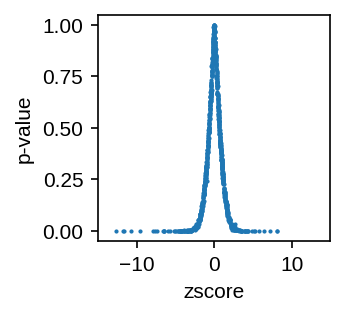

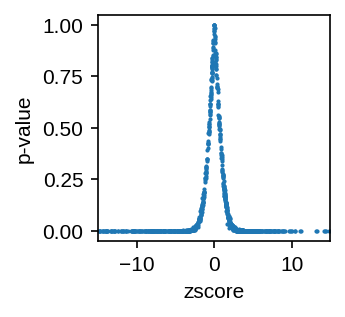

In [7]:
for group in ["white_british", "other"]:
    df_baseline, df_diff, df_diff_pval, df_diff_zscore = load_r2_result(
        result_dir=f"out/", group=group
    )

    df_baseline, df_diff, df_diff_pval, df_diff_zscore = (
        df_baseline[trait_list],
        df_diff.loc[covar_list, trait_list],
        df_diff_pval.loc[covar_list, trait_list],
        df_diff_zscore.loc[covar_list, trait_list],
    )

    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    ax.scatter(df_diff_zscore.values.flatten(), df_diff_pval.values.flatten(), s=1)
    ax.set_xlim(-15, 15)
    ax.set_xlabel("zscore")
    ax.set_ylabel("p-value")

    df_pval = df_diff_zscore.applymap(lambda x: zsc2pval(x))
    pvals = df_pval.values.flatten()
    bonferroni_threshold = pvals[
        multipletests(pvals, method="bonferroni")[1] <= 0.05
    ].max()
    fdr_threshold = pvals[multipletests(pvals, method="fdr_bh")[1] <= 0.05].max()
    print(f"##### {group}")
    print(f"Bonferroni: {bonferroni_threshold:.2g}, FDR: {fdr_threshold:.2g}")

    print(f"covariates x traits: {df_pval.shape}")
    for name, thresh in zip(
        ["bonferroni", "fdr"], [bonferroni_threshold, fdr_threshold]
    ):
        print(f"## {name} < 0.05")
        n_signif = (df_pval.values.flatten() <= thresh).sum()
        print(
            f"# Significant pairs = {n_signif} ({n_signif / df_diff_pval.size * 100:.2g}%)"
        )

        print(
            f"# PGSs with at least one significant covariate:",
            np.any(df_pval <= thresh, axis=0).sum(),
        )
        print("-" * 50)
    print("#" * 50)

# Notable examples

In [8]:
plot_pairs = [
    #  Replicate Mostafavi et al.
    ("diastolic_BP", "SEX"),
    ("log_BMI", "AGE"),
    ("years_of_edu", "DEPRIVATION_INDEX"),
    # notable examples
    ("LDL", "AGE"),
    ("LDL", "log_BMI"),
    ("myopia", "income"),
]

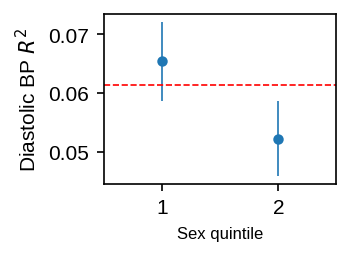

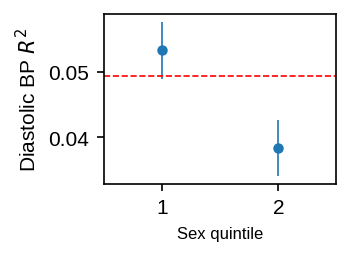

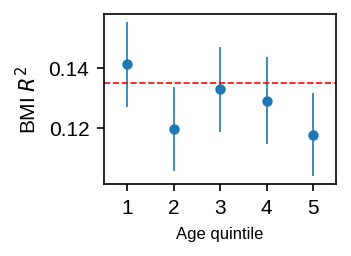

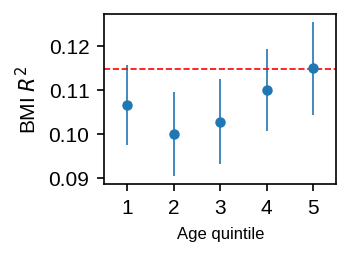

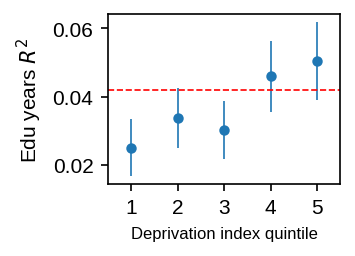

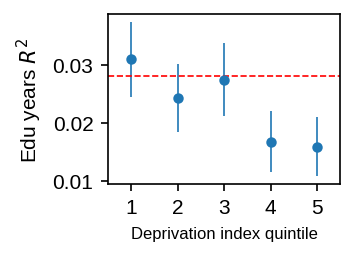

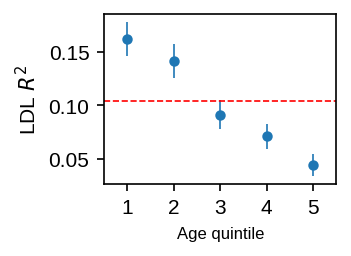

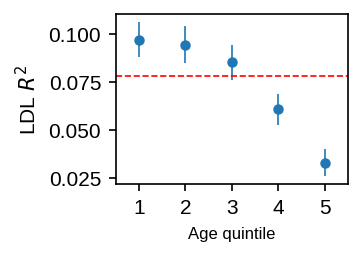

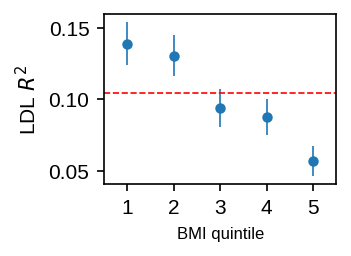

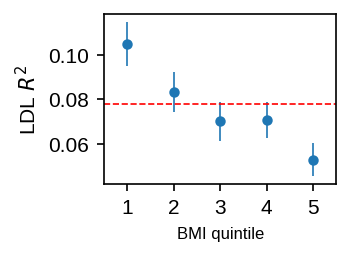

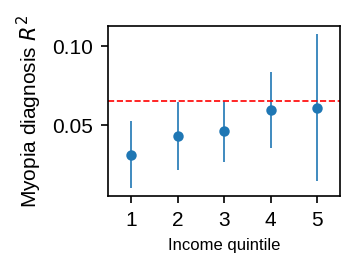

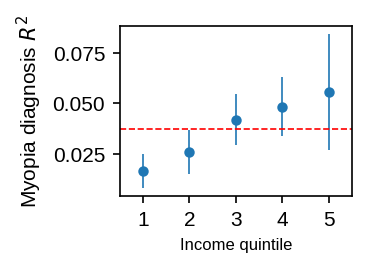

In [9]:
for trait, covar in plot_pairs:
    for group in ["white_british", "other"]:

        df_r2 = pd.read_csv(f"out/r2-diff/{trait}-{group}.r2.tsv", sep="\t")
        df_r2 = df_r2[df_r2.group == covar]
        baseline_r2 = pd.read_csv(
            f"out/r2-diff/{trait}-{group}.baseline.tsv",
            sep="\t",
            index_col=0,
            header=None,
            squeeze=True,
        )["r2"]
        fig, ax = plt.subplots(figsize=(2, 1.5), dpi=150)
        ax.errorbar(
            x=np.arange(len(df_r2)),
            y=df_r2["r2"],
            yerr=df_r2["r2_se"] * 1.96,
            fmt=".",
            markersize=8,
            lw=0.8,
        )
        ax.axhline(y=baseline_r2, color="red", lw=0.8, ls="--")
        ax.set_xlim(-0.5, len(df_r2) - 0.5)
        ax.set_ylabel(f"{trait_map[trait]} $R^2$")
        ax.set_xticks(np.arange(len(df_r2)))
        ax.set_xticklabels(np.arange(len(df_r2)) + 1)

        ax.set_xlabel(f"{covar_map[covar]} quintile", fontsize=8)

In [10]:
df_baseline, df_diff, df_diff_pval, df_diff_zscore = load_r2_result(
    result_dir=f"out/", group="white_british"
)

df_baseline, df_diff, df_diff_pval, df_diff_zscore = (
    df_baseline[trait_list],
    df_diff.loc[:, trait_list],
    df_diff_pval.loc[:, trait_list],
    df_diff_zscore.loc[:, trait_list],
)
for trait, covar in plot_pairs:
    print(
        f"{trait}, {covar}: relative R2 diff = {df_diff.loc[covar, trait]:.2g} (z = {df_diff_zscore.loc[covar, trait]:.2g})"
    )

diastolic_BP, SEX: relative R2 diff = -0.21 (z = -3)
log_BMI, AGE: relative R2 diff = -0.17 (z = -2.9)
years_of_edu, DEPRIVATION_INDEX: relative R2 diff = 0.61 (z = 4.3)
LDL, AGE: relative R2 diff = -1.1 (z = -13)
LDL, log_BMI: relative R2 diff = -0.79 (z = -9.5)
myopia, income: relative R2 diff = 0.46 (z = 1.6)
